# FasterRCNN Transfer Learning on the Trashy Dataset

## Introduction

This notebook is based on the following tutorial:

https://www.youtube.com/watch?v=qC4yEiJOJtM

A number of changes were made to the code presented in the tutorial, including:

1. Adapted preprocessing to the trashy dataset
2. Changed model to use validation loss to prevent overfitting
3. Predictions with a confidence score below 0.6 are filtered out
4. Added loss curve plotting
5. Added model saving/loading
6. Evaluation Metrics, including a Confusion Matrix and a Precision-Recall Curve were added

The following Packages must be installed:

- `torch`
- `torchvision`
- `numpy`
- `pandas`
- `pycocotools`
- `pillow`
- `matplotlib`

A pre-trained model may be download from the following google drive link, and should be placed in the same directory as this notebook for use:

https://drive.google.com/file/d/11zKirXb7rvPcw7WkUwwCqQFWwvd2JnhF/view?usp=drive_link

*Note: This notebook was developed and ran on* ***Google Colab.*** *Inference was tested locally, however training and evaluation were not*

In [1]:
# Install Packages

!pip install torch torchvision

!pip install numpy pandas pycocotools pillow matplotlib

*The below cell is only relevant if running the notebook on* ***Google Colab.***

*When running locally, this cell may be skipped. Make sure that the dataset in* *`.coco`* *format is in the same directory as this notebook*

*When running on* ***Google Colab,*** *Change* *`%cd /content/drive/My\ Drive/University/adv_cv`* *to the directory containing the dataset in* *`.coco`* *format.*

In [2]:
# Change to appropriate dir

%cd /content/drive/My\ Drive/University/adv_cv

/content/drive/My Drive/University/adv_cv


In [3]:
# Imports

import numpy as np
import pandas as pd
import os
import time
import random

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import box_iou

from pycocotools.coco import COCO

from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

from PIL import Image

## Preprocessing

In [4]:
# Dataset paths

train_ann = 'trashy_dataset.coco/train/_annotations.coco.json'
valid_ann = 'trashy_dataset.coco/valid/_annotations.coco.json'
test_ann = 'trashy_dataset.coco/test/_annotations.coco.json'

In [5]:
# Function for loading from coco dataset and converting to appropriate format

def load_coco_annotations(annotation_path, image_base_path):
    coco = COCO(annotation_path)
    annotations = coco.loadAnns(coco.getAnnIds())

    rows = []

    for ann in annotations:
        image_id = ann['image_id']
        image_info = coco.loadImgs(image_id)[0]
        image_path = os.path.join(image_base_path, image_info['file_name'])
        bbox = ann['bbox']
        x1, y1, width, height = bbox
        x2, y2 = x1 + width, y1 + height
        label = ann['category_id']

        rows.append({
            'image_id': image_path,
            'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2,
            'label': label
        })

    return pd.DataFrame(rows)

In [6]:
df_train = load_coco_annotations(train_ann, 'trashy_dataset.coco/train')
df_valid = load_coco_annotations(valid_ann, 'trashy_dataset.coco/valid')
df_test = load_coco_annotations(test_ann, 'trashy_dataset.coco/test')

loading annotations into memory...
Done (t=5.06s)
creating index...
index created!
loading annotations into memory...
Done (t=1.24s)
creating index...
index created!
loading annotations into memory...
Done (t=1.83s)
creating index...
index created!


In [7]:
df_train.head()

image_id   x1   y1       x2  \
0  trashy_dataset.coco/train/MSIDA_35_jpg.rf.ff8e...  206   61  472.247   
1  trashy_dataset.coco/train/MSIDA_35_jpg.rf.ff8e...  335  122  433.619   
2  trashy_dataset.coco/train/MSIDA_35_jpg.rf.ff8e...  181  206  345.641   
3  trashy_dataset.coco/train/IMG_1792-2_JPG.rf.fd...  238  124  383.910   
4  trashy_dataset.coco/train/MSIDA_51_jpg.rf.ff61...  281  241  338.000   

        y2  label  
0  432.098      3  
1  435.211      3  
2  436.771      3  
3  236.511      2  
4  271.500      2

In [8]:
class CustDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.unique_imgs = df.image_id.unique()

    def __len__(self):
        return len(self.unique_imgs)

    def __getitem__(self, idx):
        image_name = self.unique_imgs[idx]
        image_data = self.df[self.df.image_id == image_name]

        boxes_np = image_data[['x1', 'y1', 'x2', 'y2']].to_numpy(dtype=np.float32, copy=True)
        labels_np = image_data['label'].to_numpy(dtype=np.int64, copy=True)

        boxes = torch.as_tensor(boxes_np, dtype=torch.float32)
        labels = torch.as_tensor(labels_np, dtype=torch.int64)

        img = Image.open(image_name).convert("RGB")
        img_tensor = T.ToTensor()(img)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        return img_tensor, target

In [9]:
# Placeholder custom collate

def custom_collate(data):
    return data

# Training print functions

def print_training_progress(epoch, num_epochs, batch, num_batches, loss, start_time):
    elapsed_time = time.time() - start_time
    clear_output(wait=True)
    print(f"Epoch: {epoch}/{num_epochs} | Batch: {batch}/{num_batches} | Loss: {loss:.4f} | Time Elapsed: {elapsed_time:.2f}s")

def print_epoch_summary(epoch, num_epochs, avg_loss, epoch_start_time):
    epoch_duration = time.time() - epoch_start_time
    clear_output(wait=True)
    print(f"\n[Epoch {epoch}/{num_epochs}] Completed | Average Loss: {avg_loss:.4f} | Duration: {epoch_duration:.2f}s")

def print_validation_progress(epoch, num_epochs, batch, num_batches, loss, start_time):
    elapsed_time = time.time() - start_time
    clear_output(wait=True)
    print(f"Validation | Epoch: {epoch}/{num_epochs} | Batch: {batch}/{num_batches} | Loss: {loss:.4f} | Time Elapsed: {elapsed_time:.2f}s")

# Early Stopping

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def check(self, val_loss):

        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter when improvement is seen
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [10]:
# Initialize datasets
train_dataset = CustDataset(df_train)
valid_dataset = CustDataset(df_valid)
test_dataset = CustDataset(df_test)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate, pin_memory=True if torch.cuda.is_available() else False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate, pin_memory=True if torch.cuda.is_available() else False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate, pin_memory=True if torch.cuda.is_available() else False)

## Training

In [11]:
# Load pre-trained model

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
num_classes = 5 # 4 classes + background class
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon with Metal Performance Shaders (MPS).")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 220MB/s]


Using CUDA.


In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 50
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
train_loss_history = []
val_loss_history = []
final_num_epochs = 0

score_threshold = 0.6 # This is not a training hyperparameter: it is used to filter low confidence bounding boxes during inference


[Epoch 11/50] Completed | Average Loss: 0.3449 | Duration: 44.95s
Early stopping triggered after 11 epochs.


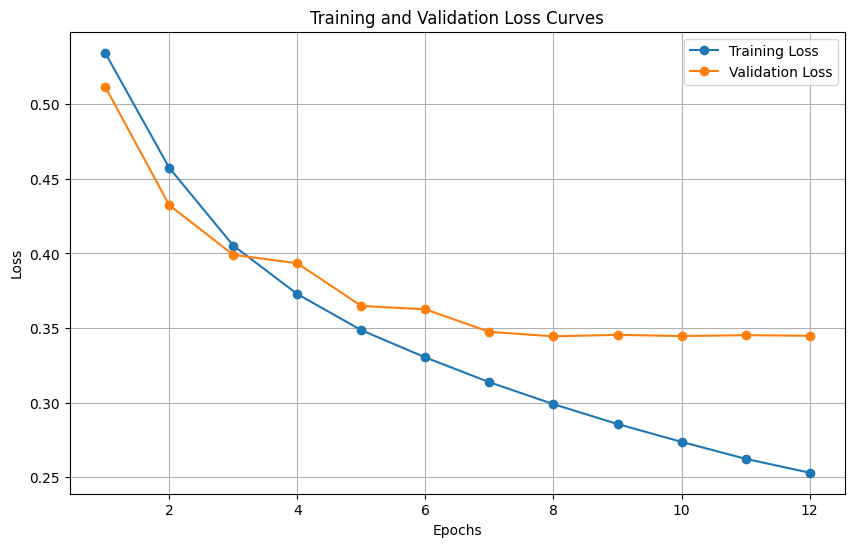

In [ ]:
# Skip this cell when using a pre-trained model

model.to(device)

start_time = time.time()

# Training

for epoch in range(num_epochs):

    epoch_loss = 0
    epoch_val_loss = 0
    epoch_start_time = time.time()

    model.train()

    for i, data in enumerate(train_loader):
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["labels"].to(device)
            targets.append(targ)

        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_training_progress(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item(), start_time)

    avg_train_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        val_start_time = time.time()
        for i, data in enumerate(valid_loader):
            imgs = []
            targets = []
            for d in data:
                imgs.append(d[0].to(device))
                targ = {}
                targ["boxes"] = d[1]["boxes"].to(device)
                targ["labels"] = d[1]["labels"].to(device)
                targets.append(targ)

            model.train()
            val_loss_dict = model(imgs, targets)
            model.eval()

            val_loss = sum(v for v in val_loss_dict.values())
            epoch_val_loss += val_loss.cpu().detach().numpy()

            print_validation_progress(epoch + 1, num_epochs, i + 1, len(valid_loader), val_loss, val_start_time)

    avg_val_loss = epoch_val_loss / len(valid_loader)
    val_loss_history.append(avg_val_loss)

    print_epoch_summary(epoch + 1, num_epochs, avg_val_loss, epoch_start_time)

    torch.save(model.state_dict(), f"FasterRCNN_epoch={epoch+1}.pth")

    early_stopping.check(avg_val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        final_num_epochs = epoch + 1
        break

# Loss curves

print(f"Training completed after {final_num_epochs} epochs.")
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, marker='o', label='Training Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation and Inference

In [13]:
checkpoint_path = "FasterRCNN_epoch=11.pth"
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))

<All keys matched successfully>

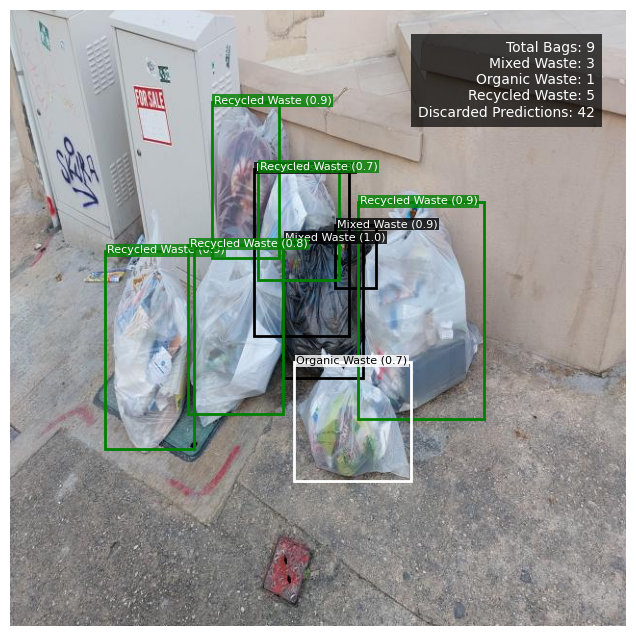

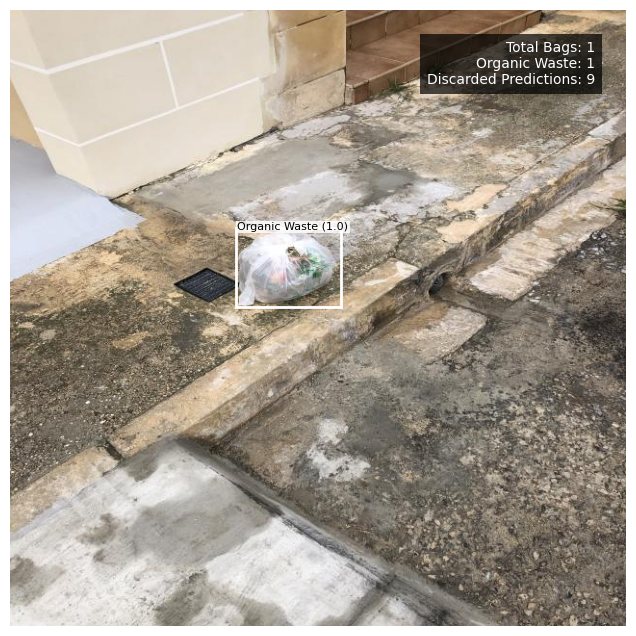

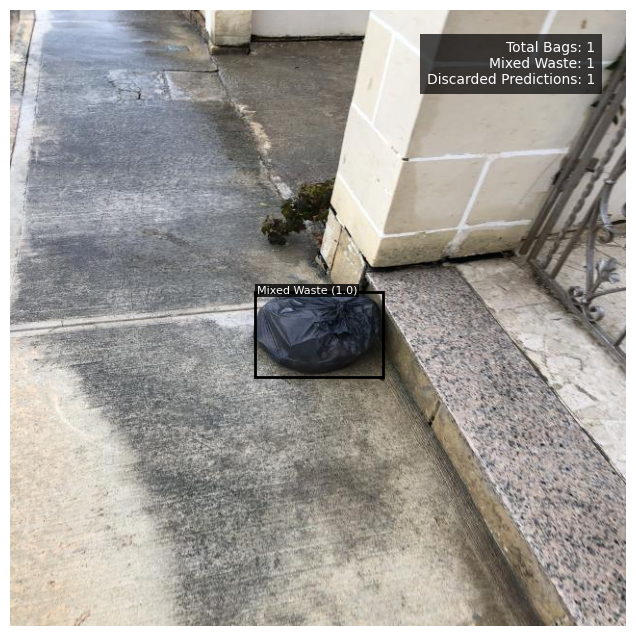

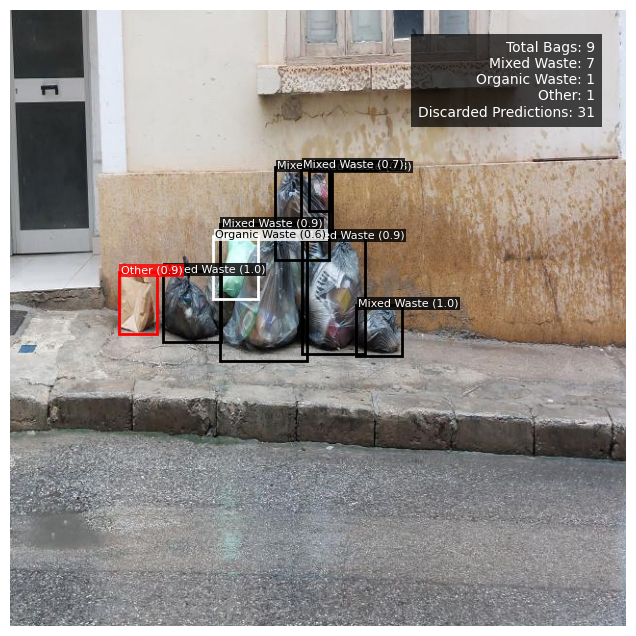

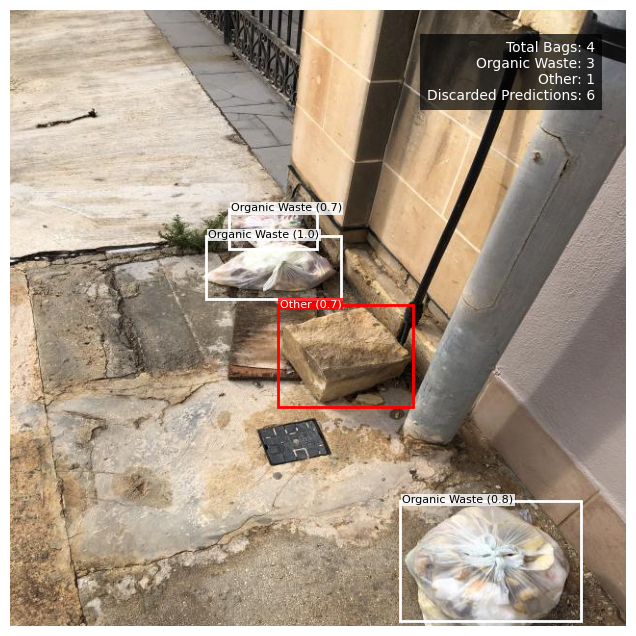

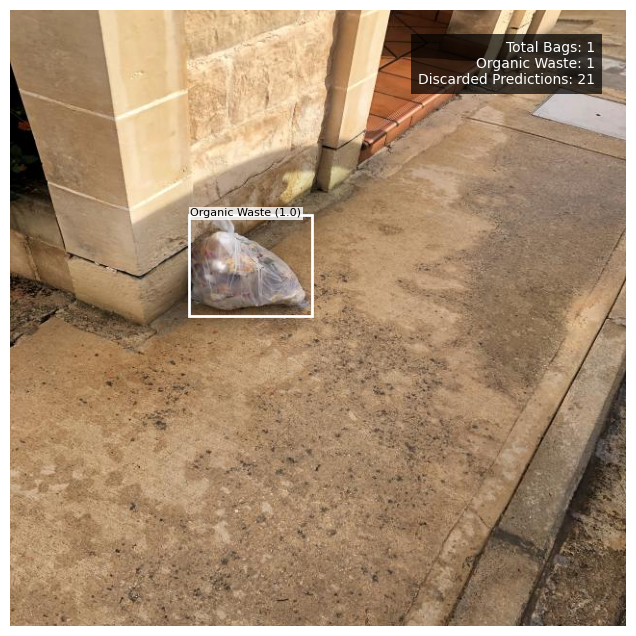

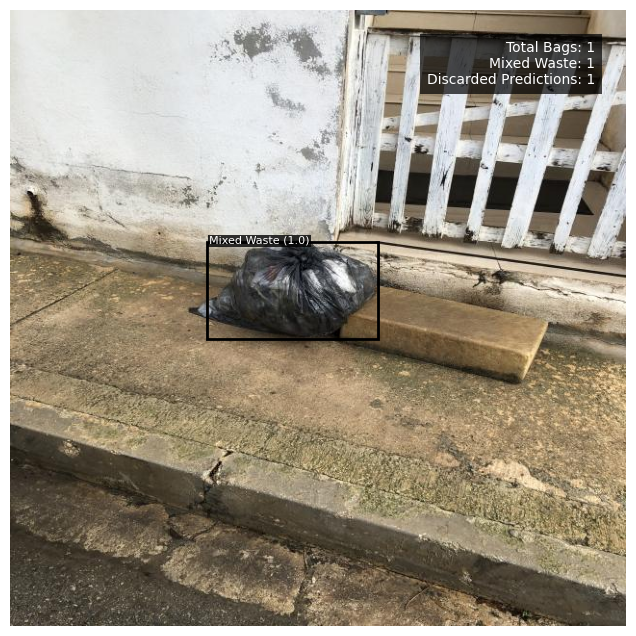

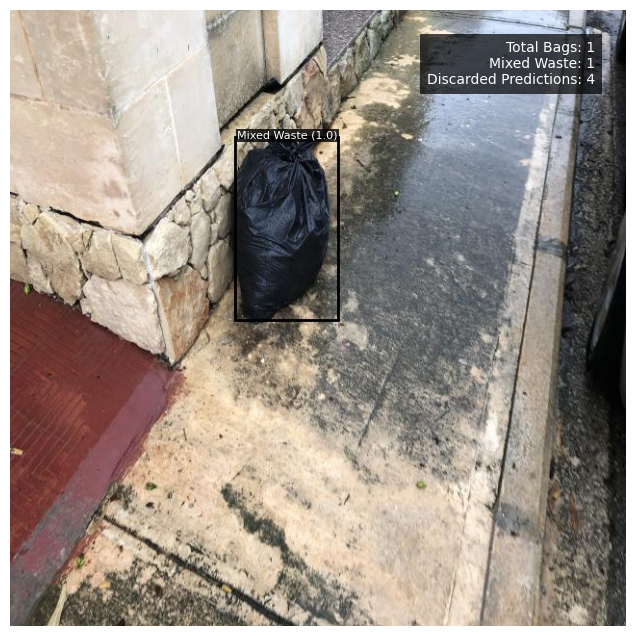

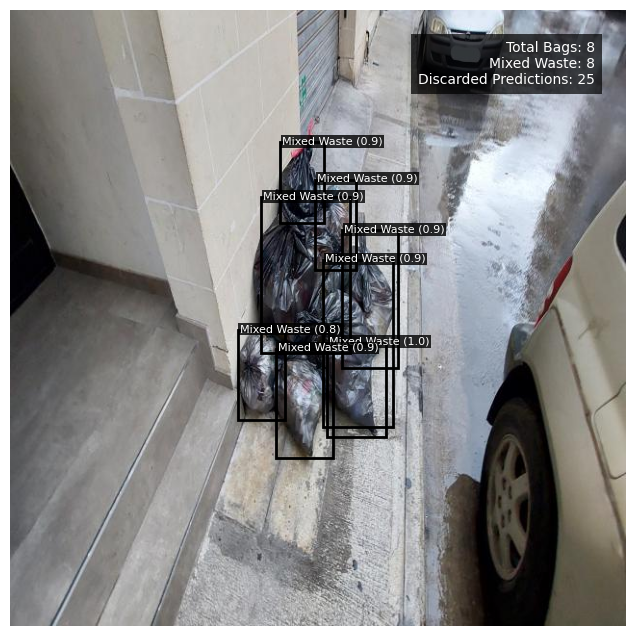

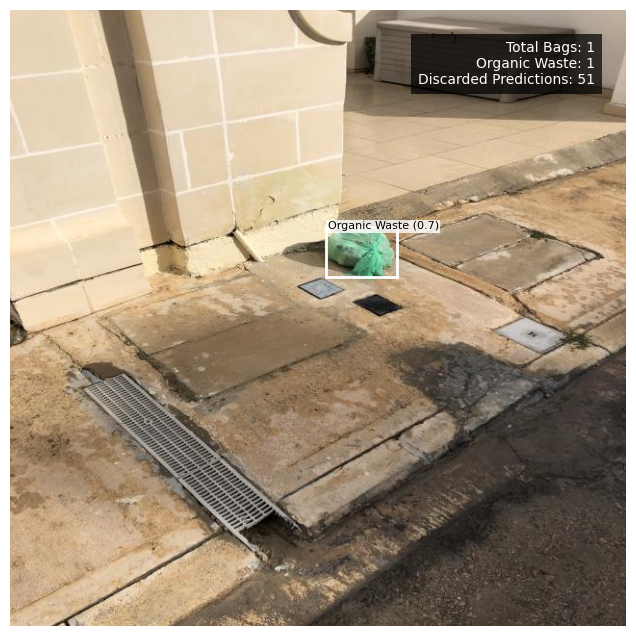

In [22]:
class_names = ["Background", "Mixed Waste", "Organic Waste", "Other", "Recycled Waste"]

# Define the colors for each class
class_colors = {
    "Mixed Waste": "black",
    "Organic Waste": "white",
    "Other": "red",
    "Recycled Waste": "green"
}

def display_predictions(img_tensor, predictions, class_names):
    img = to_pil_image(img_tensor)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()

    class_counts = {class_name: 0 for class_name in class_names}

    # Filter predictions based on score threshold
    score_threshold = 0.6
    filtered_predictions = {
        "boxes": predictions["boxes"][predictions["scores"] > score_threshold],
        "labels": predictions["labels"][predictions["scores"] > score_threshold],
        "scores": predictions["scores"][predictions["scores"] > score_threshold]
    }
    discarded_predictions = len(predictions["scores"]) - len(filtered_predictions["scores"])

    for box, label, score in zip(filtered_predictions['boxes'], filtered_predictions['labels'], filtered_predictions['scores']):
        x1, y1, x2, y2 = box.tolist()
        class_name = class_names[label.item()]
        color = class_colors.get(class_name, "blue")  # Default color is blue if class not in class_colors

        class_counts[class_name] += 1

        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2))
        ax.text(
            x1 + 2, y1 + 2, f"{class_name} ({score:.1f})",
            color='white' if color != "white" else "black", fontsize=8,
            bbox=dict(facecolor=color, alpha=0.8, edgecolor='none', pad=1)
        )

    total_instances = sum(class_counts.values())
    stats_text = f"Total Bags: {total_instances}\n"
    stats_text += "\n".join([f"{class_name}: {count}" for class_name, count in class_counts.items() if count > 0])
    stats_text += f"\nDiscarded Predictions: {discarded_predictions}"

    plt.text(
        0.95, 0.95, stats_text,
        transform=ax.transAxes, fontsize=10,
        color='white', bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', pad=5),
        verticalalignment='top', horizontalalignment='right'
    )

    plt.axis('off')
    plt.show()

model.to(device)
model.eval()

random_indices = random.sample(range(len(test_dataset)), 10)

for idx in random_indices:
    img_tensor, target = test_dataset[idx]

    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        prediction = model([img_tensor])

    predictions = {
        "boxes": prediction[0]['boxes'].cpu(),
        "labels": prediction[0]['labels'].cpu(),
        "scores": prediction[0]['scores'].cpu()
    }

    display_predictions(img_tensor.cpu(), predictions, class_names)


In [15]:
def greedy_iou_matching(predictions, ground_truth, iou_threshold=0.5):
    iou_matrix = box_iou(predictions["boxes"], ground_truth["boxes"])

    matched_preds = set()
    matched_gts = set()
    matches = []

    for gt_idx, gt_box in enumerate(ground_truth["boxes"]):

        pred_idx = iou_matrix[:, gt_idx].argmax().item()
        max_iou = iou_matrix[pred_idx, gt_idx].item()

        if max_iou >= iou_threshold and pred_idx not in matched_preds:

            matches.append((pred_idx, gt_idx))
            matched_preds.add(pred_idx)
            matched_gts.add(gt_idx)

    unmatched_preds = [i for i in range(len(predictions["boxes"])) if i not in matched_preds]
    unmatched_gts = [i for i in range(len(ground_truth["boxes"])) if i not in matched_gts]

    return matches, unmatched_preds, unmatched_gts

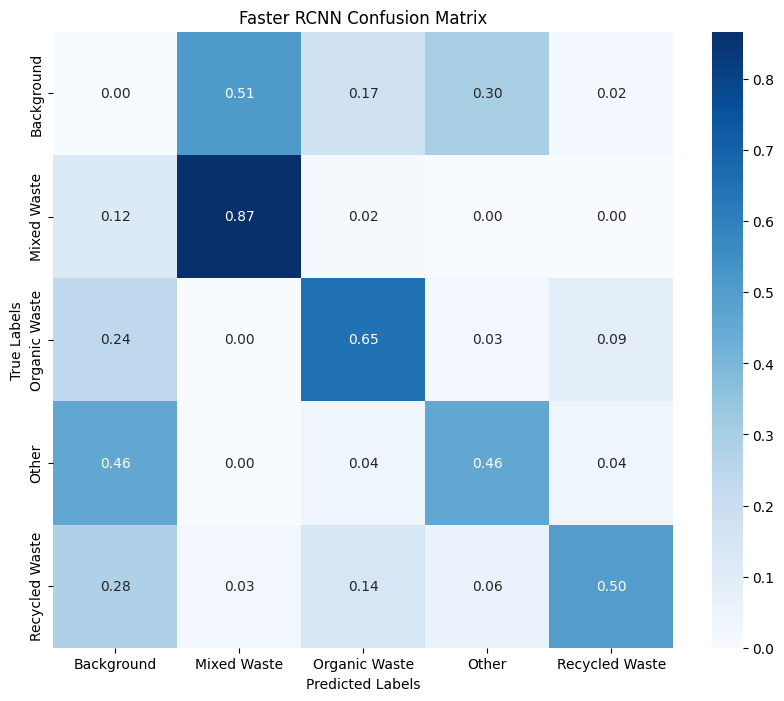

In [16]:
class_names = ["Background", "Mixed Waste", "Organic Waste", "Other", "Recycled Waste"]

conf_matrix = np.zeros((len(class_names), len(class_names)), dtype=int)

model.to(device)
model.eval()

for idx in range(len(test_dataset)):
    img_tensor, target = test_dataset[idx]

    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        prediction = model([img_tensor])

    predictions = {
        "boxes": prediction[0]['boxes'].cpu(),
        "labels": prediction[0]['labels'].cpu(),
        "scores": prediction[0]['scores'].cpu()
    }

    filt_predictions = {
        "boxes": predictions["boxes"][predictions["scores"] > score_threshold],
        "labels": predictions["labels"][predictions["scores"] > score_threshold],
        "scores": predictions["scores"][predictions["scores"] > score_threshold]
    }

    ground_truth = {
        "boxes": target['boxes'],
        "labels": target['labels']
    }

    matches, unmatched_preds, unmatched_gts = greedy_iou_matching(filt_predictions, ground_truth)

    for pred_idx, gt_idx in matches:
        pred_label = filt_predictions["labels"][pred_idx].item()
        gt_label = ground_truth["labels"][gt_idx].item()
        conf_matrix[gt_label, pred_label] += 1

    for pred_idx in unmatched_preds:
        pred_label = filt_predictions["labels"][pred_idx].item()
        conf_matrix[0, pred_label] += 1

    for gt_idx in unmatched_gts:
        gt_label = ground_truth["labels"][gt_idx].item()
        conf_matrix[gt_label, 0] += 1

conf_matrix_normalized = conf_matrix.astype(np.float32) / conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_normalized = np.nan_to_num(conf_matrix_normalized)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_normalized,
    annot=True,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    fmt=".2f"
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Faster RCNN Confusion Matrix")
plt.show()


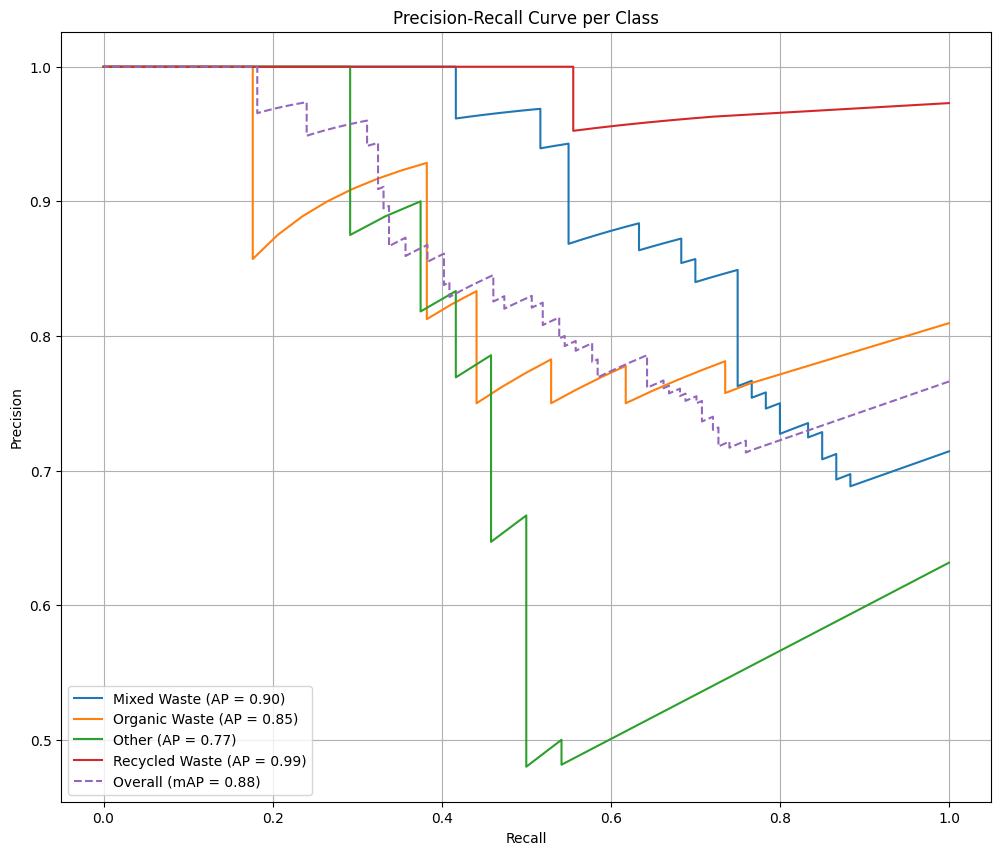

In [ ]:
class_names = ["Background", "Mixed Waste", "Organic Waste", "Other", "Recycled Waste"]

class_scores = {class_name: [] for class_name in class_names}
class_labels = {class_name: [] for class_name in class_names}

model.to(device)
model.eval()

for idx in range(len(test_dataset)):
    img_tensor, target = test_dataset[idx]

    img_tensor = img_tensor.to(device)

    with torch.no_grad():
        prediction = model([img_tensor])

    predictions = {
        "boxes": prediction[0]['boxes'].cpu(),
        "labels": prediction[0]['labels'].cpu(),
        "scores": prediction[0]['scores'].cpu()
    }

    filt_predictions = {
    "boxes": predictions["boxes"][predictions["scores"] > score_threshold],
    "labels": predictions["labels"][predictions["scores"] > score_threshold],
    "scores": predictions["scores"][predictions["scores"] > score_threshold]
    }

    ground_truth = {
        "boxes": target['boxes'],
        "labels": target['labels']
    }

    matches, unmatched_preds, unmatched_gts = greedy_iou_matching(filt_predictions, ground_truth)

    for pred_idx, gt_idx in matches:
        pred_label = filt_predictions["labels"][pred_idx].item()
        gt_label = ground_truth["labels"][gt_idx].item()
        class_scores[class_names[gt_label]].append(filt_predictions["scores"][pred_idx].item())
        class_labels[class_names[gt_label]].append(1)

    for pred_idx in unmatched_preds:
        pred_label = filt_predictions["labels"][pred_idx].item()
        class_scores[class_names[pred_label]].append(filt_predictions["scores"][pred_idx].item())
        class_labels[class_names[pred_label]].append(0)

    for gt_idx in unmatched_gts:
        gt_label = ground_truth["labels"][gt_idx].item()
        class_scores[class_names[gt_label]].append(0)
        class_labels[class_names[gt_label]].append(1)

average_precisions = {}
for class_name in class_names[1:]:
    average_precisions[class_name] = average_precision_score(class_labels[class_name], class_scores[class_name])

map_score = np.mean(list(average_precisions.values()))

plt.figure(figsize=(12, 10))
for class_name in class_names[1:]:
    precision, recall, _ = precision_recall_curve(class_labels[class_name], class_scores[class_name])
    ap = average_precisions[class_name]
    plt.plot(recall, precision, label=f"{class_name} (AP = {ap:.2f})")

all_scores = sum([class_scores[class_name] for class_name in class_names[1:]], [])
all_labels = sum([class_labels[class_name] for class_name in class_names[1:]], [])
overall_precision, overall_recall, _ = precision_recall_curve(all_labels, all_scores)
plt.plot(overall_recall, overall_precision, label=f"Overall (mAP = {map_score:.2f})", linestyle='--')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Class")
plt.legend()
plt.grid()
plt.show()


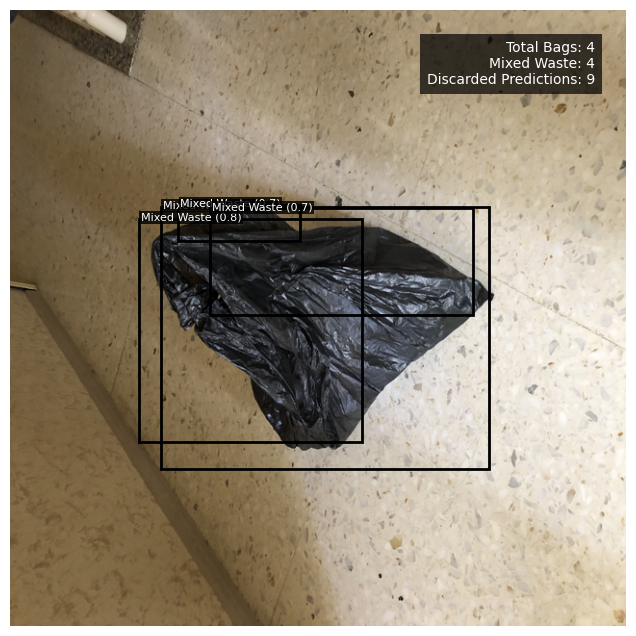

In [20]:
class_colors = {
    "Mixed Waste": "black",
    "Organic Waste": "white",
    "Other": "red",
    "Recycled Waste": "green"
}

def run_inference(image_path, model, device, class_names, score_threshold=0.6):

    img = Image.open(image_path).convert("RGB")
    img = img.resize((640, 640))
    img_tensor = T.ToTensor()(img).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model([img_tensor])

    predictions = {
        "boxes": prediction[0]['boxes'].cpu(),
        "labels": prediction[0]['labels'].cpu(),
        "scores": prediction[0]['scores'].cpu()
    }

    filtered_predictions = {
        "boxes": predictions["boxes"][predictions["scores"] > score_threshold],
        "labels": predictions["labels"][predictions["scores"] > score_threshold],
        "scores": predictions["scores"][predictions["scores"] > score_threshold]
    }

    discarded_predictions = len(predictions["scores"]) - len(filtered_predictions["scores"])

    class_counts = {class_name: 0 for class_name in class_names}
    for label in filtered_predictions["labels"]:
        class_counts[class_names[label.item()]] += 1

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    ax = plt.gca()

    for box, label, score in zip(filtered_predictions['boxes'], filtered_predictions['labels'], filtered_predictions['scores']):
        x1, y1, x2, y2 = box.tolist()
        class_name = class_names[label.item()]
        color = class_colors.get(class_name, "blue")  # Default color is blue if class not in class_colors

        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2))
        ax.text(
            x1 + 2, y1 + 2, f"{class_name} ({score:.1f})",
            color='white' if color != "white" else "black", fontsize=8,
            bbox=dict(facecolor=color, alpha=0.8, edgecolor='none', pad=1)
        )

    total_instances = sum(class_counts.values())
    stats_text = f"Total Bags: {total_instances}\n"
    stats_text += "\n".join([f"{class_name}: {count}" for class_name, count in class_counts.items() if count > 0])
    stats_text += f"\nDiscarded Predictions: {discarded_predictions}"

    plt.text(
        0.95, 0.95, stats_text,
        transform=ax.transAxes, fontsize=10,
        color='white', bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', pad=5),
        verticalalignment='top', horizontalalignment='right'
    )

    plt.axis('off')
    plt.show()


run_inference("IMG_2130.JPG", model, device, class_names, score_threshold=0.6)
